**Predicción de si una empresa será zombi 6 años despues**

Cada fila del dataset se corresponde con los **datos de una empresa en un trienio** mas la variable ZombieTarget, que valdrá 1 si esa empresa es zombi trasnscurridos 6 años con respecto a ese trienio. (Será zombi si tienen la tasa de zombificación igual a 1 durante al menos tres años consecutivos)


**Predictores del modelo:**



**Año** (último año del trieno al que se correponden las variables financieras)

**Variable Zombi del trienio**

**Variable objetivo:**

**ZombiTarget**

No se tendrán en cuenta como predictoras las variables  del periodo 2017-2022





In [ ]:
import pandas as pd
#from google.colab import drive
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,cross_val_score

from sklearn.metrics import confusion_matrix,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE,ADASYN,KMeansSMOTE

from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Conv1D, GlobalMaxPooling1D,InputLayer,Flatten

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import uniform, randint
import shap


In [ ]:
def balanced_accuracy(y_true, y_pred):





    tp = sum((y_true == 1) & (y_pred == 1))  # True Positives
    tn = sum((y_true == 0) & (y_pred == 0))  # True Negatives
    fp = sum((y_true == 0) & (y_pred == 1))  # False Positives
    fn = sum((y_true == 1) & (y_pred == 0))  # False Negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    balanced_accuracy = (sensitivity + specificity) / 2

    return balanced_accuracy

In [ ]:

ruta='../../../data/'


df_final = pd.read_csv(ruta+'dfFinal.csv')



In [ ]:
df_final.head(10)


,ID,año,AC,Endeudamiento,FondoManiobra,PT,R,RAGXFI,RAIE,Solvencia,Zombi,SECTOR,RANGO_INGRESOS,EMPLEADOS,EDAD_EMPRESA,TIPOSOC
0,233151.0,0.000000,0.023913,0.453292,0.476216,0.358907,0.476216,0.001411,0.040485,0.080816,0.0,0.352941,0.5,0.038114,0.460784,1.0
1,233151.0,0.083333,0.026300,0.463274,0.471618,0.355629,0.471618,0.001411,0.043602,0.064498,0.0,0.352941,0.5,0.038114,0.460784,1.0
2,233151.0,0.166667,0.030259,0.488989,0.473764,0.355992,0.473764,0.001411,0.052536,0.059908,0.0,0.352941,0.5,0.038114,0.460784,1.0
3,233151.0,0.250000,0.038109,0.507304,0.499606,0.359846,0.499606,0.001411,0.056812,0.059818,0.0,0.352941,0.5,0.038114,0.460784,1.0
4,233151.0,0.333333,0.022514,0.481316,0.475650,0.360398,0.475650,0.007388,0.046632,0.103046,1.0,0.352941,0.5,0.038114,0.460784,1.0
5,233151.0,0.416667,0.018757,0.475423,0.471638,0.359969,0.471638,0.003831,0.021428,0.143310,0.0,0.352941,0.5,0.038114,0.460784,1.0
6,233151.0,0.500000,0.025415,0.478861,0.472171,0.359646,0.472171,0.000274,0.017839,0.082524,0.0,0.352941,0.5,0.038114,0.460784,1.0
7,233151.0,0.583333,0.025115,0.437031,0.482414,0.344837,0.482414,0.000158,0.020914,0.091303,0.0,0.352941,0.5,0.038114,0.460784,1.0
8,233151.0,0.666667,0.025089,0.434540,0.478409,0.345915,0.478409,0.000143,0.029336,0.101137,0.0,0.352941,0.5,0.038114,0.460784,1.0
9,233151.0,0.750000,0.030902,0.445329,0.478157,0.364152,0.478157,0.000264,0.021016,0.077522,0.0,0.352941,0.5,0.038114,0.460784,1.0


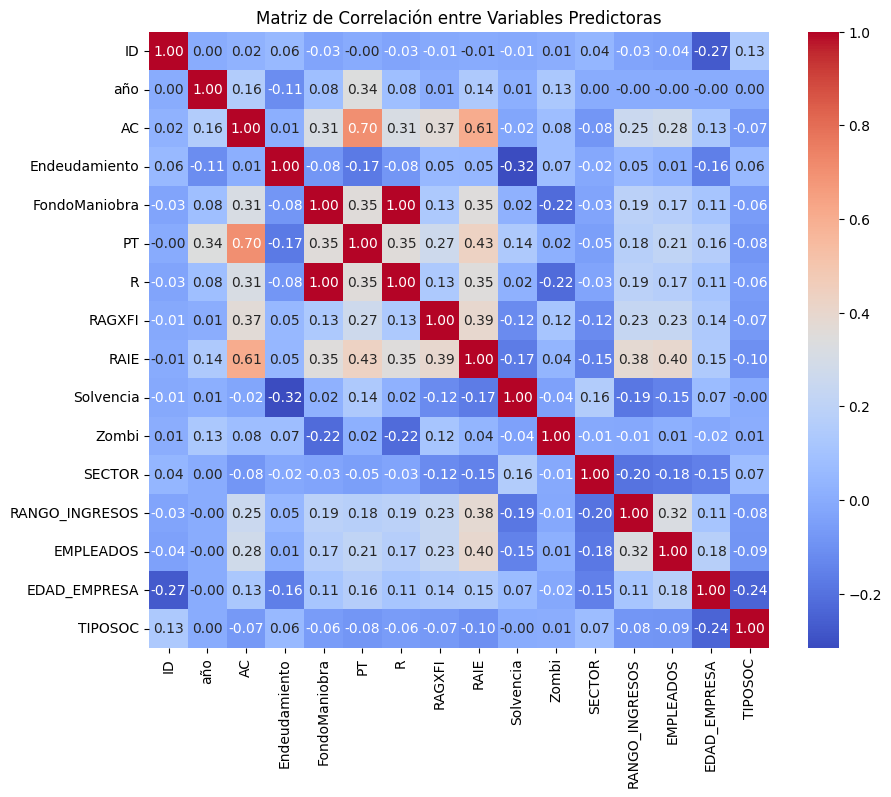

In [ ]:
#Estudio de correlación
correlaciones =df_final.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación entre Variables Predictoras")
plt.show()

In [ ]:
#Se quitan como variables predictoras los gastos, los resultados y los dfondos maniobra, que  tienen los mismo datoso que los resultados

df_final.drop('FondoManiobra', axis=1, inplace=True)
df_final.drop('RAGXFI', axis=1, inplace=True)
df_final.drop('R', axis=1, inplace=True)


**Preparación del dataset**

Se parte del dataset final, que contiene las variables por empresa y año.

Para cada fila se incluyen las variables de esa empresa de los dos años anteriores para conformar así todos los datos de esa compañía para un trienio dado.

Además para cada fila se genera la variable objetivo ZombiTarget considerando los valores Zombis  del trienio que se quiere predecir

In [ ]:


df_final.sort_values(by=['ID', 'año'], inplace=True)

df_final['ZombiTarget'] = (df_final.groupby('ID')['Zombi'].shift(-4).fillna(0).astype(int) &
                           df_final.groupby('ID')['Zombi'].shift(-5).fillna(0).astype(int) &
                           df_final.groupby('ID')['Zombi'].shift(-6).fillna(0).astype(int))



df_final['Zombi'] = (df_final['Zombi'].astype(int) &
                           df_final.groupby('ID')['Zombi'].shift(2).fillna(0).astype(int) &
                           df_final.groupby('ID')['Zombi'].shift(1).fillna(0).astype(int))




df_final['ACPrevio'] = df_final.groupby('ID')['AC'].shift(1)
df_final['ACPrevio'] = df_final['ACPrevio'].fillna(df_final['ACPrevio'].mean())

df_final['ACPrevio2'] = df_final.groupby('ID')['AC'].shift(2)
df_final['ACPrevio2'] = df_final['ACPrevio2'].fillna(df_final['ACPrevio2'].mean())

df_final['EndeudamientoPrevio'] = df_final.groupby('ID')['Endeudamiento'].shift(1)
df_final['EndeudamientoPrevio'] = df_final['EndeudamientoPrevio'].fillna(df_final['EndeudamientoPrevio'].mean())


df_final['EndeudamientoPrevio2'] = df_final.groupby('ID')['Endeudamiento'].shift(2)
df_final['EndeudamientoPrevio2'] = df_final['EndeudamientoPrevio2'].fillna(df_final['EndeudamientoPrevio2'].mean())

df_final['PTPrevio'] = df_final.groupby('ID')['PT'].shift(1)
df_final['PTPrevio'] = df_final['PTPrevio'].fillna(df_final['PTPrevio'].mean())

df_final['PTPrevio2'] = df_final.groupby('ID')['PT'].shift(2)
df_final['PTPrevio2'] = df_final['PTPrevio2'].fillna(df_final['PTPrevio2'].mean())



df_final['RAIEPrevio'] = df_final.groupby('ID')['RAIE'].shift(1)
df_final['RAIEPrevio'] = df_final['RAIEPrevio'].fillna(df_final['RAIEPrevio'].mean())

df_final['RAIEPrevio2'] = df_final.groupby('ID')['RAIE'].shift(2)
df_final['RAIEPrevio2'] = df_final['RAIEPrevio2'].fillna(df_final['RAIEPrevio2'].mean())

df_final['SolvenciaPrevia'] = df_final.groupby('ID')['Solvencia'].shift(1)
df_final['SolvenciaPrevia'] = df_final['SolvenciaPrevia'].fillna(df_final['SolvenciaPrevia'].mean())

df_final['SolvenciaPrevia2'] = df_final.groupby('ID')['Solvencia'].shift(2)
df_final['SolvenciaPrevia2'] = df_final['SolvenciaPrevia2'].fillna(df_final['SolvenciaPrevia2'].mean())





In [ ]:
#Calculo los deltas de ese trienio

df_final["DeltaAC"]=(df_final["AC"]-df_final["ACPrevio2"])
df_final["DeltaEndeudamiento"]=(df_final["Endeudamiento"]-df_final["EndeudamientoPrevio2"])
df_final["DeltaRAIE"]=(df_final["RAIE"]-df_final["RAIEPrevio2"])
df_final["DeltaSolvencia"]=(df_final["Solvencia"]-df_final["SolvenciaPrevia2"])
df_final["DeltaPT"]=(df_final["PT"]-df_final["PTPrevio2"])



# Crear el objeto scaler
#scaler = StandardScaler()
colsdelta=["DeltaEndeudamiento","DeltaAC","DeltaRAIE","DeltaSolvencia","DeltaPT"]
"""
for columna in colsdelta:
    min_col = df_final[columna].min()
    max_col = df_final[columna].max()
    df_final[columna] = (df_final[columna] - min_col) / (max_col - min_col)
"""

df_final[colsdelta]


,DeltaEndeudamiento,DeltaAC,DeltaRAIE,DeltaSolvencia,DeltaPT
0,-0.034273,-0.034217,-0.008534,-0.046996,-0.021965
1,-0.024291,-0.031830,-0.005417,-0.063314,-0.025243
2,0.035697,0.006346,0.012051,-0.020908,-0.002914
3,0.044030,0.011809,0.013210,-0.004680,0.004217
4,-0.007673,-0.007745,-0.005904,0.043138,0.004406
...,...,...,...,...,...
159453,-0.073731,0.019916,0.025076,0.124947,0.031598
159454,-0.017547,0.029530,0.004407,0.078618,0.067988
159455,0.000988,0.012832,-0.014154,0.028564,0.064974
159456,-0.004702,0.022096,0.011837,0.439923,0.095804


In [ ]:
#Quito los datos de los años 2017-2022

df_final=df_final[df_final["año"]<=0.5]

In [ ]:
(df_final["ZombiTarget"]==1).sum()/len(df_final)

0.037967901982250585

In [ ]:


# Correlación con el target
correlacion_con_target = df_final.corrwith(df_final['ZombiTarget'])
print("Correlación con el target:\n", correlacion_con_target)

Correlación con el target:
 ID                      0.010702
año                    -0.062158
AC                      0.071163
Endeudamiento           0.008351
PT                      0.031558
RAIE                    0.058573
Solvencia              -0.031801
Zombi                   0.012407
SECTOR                 -0.024188
RANGO_INGRESOS          0.005542
EMPLEADOS               0.028603
EDAD_EMPRESA           -0.008580
TIPOSOC                 0.008145
ZombiTarget             1.000000
ACPrevio                0.065175
ACPrevio2               0.056404
EndeudamientoPrevio     0.000340
EndeudamientoPrevio2    0.003941
PTPrevio                0.029075
PTPrevio2               0.023779
RAIEPrevio              0.053478
RAIEPrevio2             0.040212
SolvenciaPrevia        -0.030199
SolvenciaPrevia2       -0.026673
DeltaAC                 0.042621
DeltaEndeudamiento      0.005883
DeltaRAIE               0.044224
DeltaSolvencia         -0.012976
DeltaPT                 0.018163
dtype: float64


In [ ]:
#AQUI SE FILTRAN DEL DATASET LAS VARIABLES QUE SE USARAN PARA ENTRENAR EL MODELO

# Preparar los datos para el modelo
#variables predictoras y target
feature_columns = ["año","Zombi"]
target_column="ZombiTarget"

X= df_final[feature_columns].values
y = df_final[target_column].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las dimensiones de los datos transformados y los predictores
(X_train.shape, X_test.shape,feature_columns)

((68689, 2), (17173, 2), ['año', 'Zombi'])

In [ ]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5) #mejora el recall

smote = SMOTE(random_state=42)


#X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = adasyn.fit_resample(X_train, y_train)
(X_train.shape, X_test.shape)

((132750, 2), (17173, 2))

In [ ]:

model_ANN = Sequential([
    InputLayer(input_shape=(X_train.shape[1],1)),
    Flatten(),
    Dense(200, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(200, activation='relu'),
    Dense(1, activation='sigmoid')
])



model_ANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_ANN.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
   # class_weight=class_weight,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/20
3319/3319 [==============================] - 21s 6ms/step - loss: 0.6429 - accuracy: 0.6221 - val_loss: 0.8290 - val_accuracy: 0.0000e+00
Epoch 2/20
3319/3319 [==============================] - 25s 8ms/step - loss: 0.6414 - accuracy: 0.6221 - val_loss: 0.8948 - val_accuracy: 0.0000e+00
Epoch 3/20
3319/3319 [==============================] - 25s 8ms/step - loss: 0.6409 - accuracy: 0.6222 - val_loss: 0.9039 - val_accuracy: 0.0000e+00
Epoch 4/20
3319/3319 [==============================] - 24s 7ms/step - loss: 0.6404 - accuracy: 0.6218 - val_loss: 0.8945 - val_accuracy: 0.0000e+00
Epoch 5/20
3319/3319 [==============================] - 29s 9ms/step - loss: 0.6403 - accuracy: 0.6219 - val_loss: 0.9339 - val_accuracy: 0.0000e+00
Epoch 6/20
3319/3319 [==============================] - 23s 7ms/step - loss: 0.6405 - accuracy: 0.6222 - val_loss: 0.8844 - val_accuracy: 0.0000e+00


In [ ]:

model_LSTM = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_LSTM.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
   # class_weight=class_weight,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/20
3319/3319 [==============================] - 42s 12ms/step - loss: 0.6445 - accuracy: 0.6220 - val_loss: 0.9136 - val_accuracy: 0.0000e+00
Epoch 2/20
3319/3319 [==============================] - 38s 12ms/step - loss: 0.6411 - accuracy: 0.6219 - val_loss: 0.8950 - val_accuracy: 0.0000e+00
Epoch 3/20
3319/3319 [==============================] - 36s 11ms/step - loss: 0.6407 - accuracy: 0.6220 - val_loss: 0.9066 - val_accuracy: 0.0000e+00
Epoch 4/20
3319/3319 [==============================] - 35s 10ms/step - loss: 0.6407 - accuracy: 0.6219 - val_loss: 0.9384 - val_accuracy: 0.0000e+00
Epoch 5/20
3319/3319 [==============================] - 37s 11ms/step - loss: 0.6404 - accuracy: 0.6221 - val_loss: 0.8980 - val_accuracy: 0.0000e+00
Epoch 6/20
3319/3319 [==============================] - 38s 11ms/step - loss: 0.6405 - accuracy: 0.6222 - val_loss: 0.9039 - val_accuracy: 0.0000e+00
Epoch 7/20
3319/3319 [==============================] - 37s 11ms/step - loss: 0.6405 - accuracy: 0.6

In [ ]:
# Creación de un DataFrame para almacenar las métricas
df_metricas = pd.DataFrame(index=["ANN","LTSM"])

537/537 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


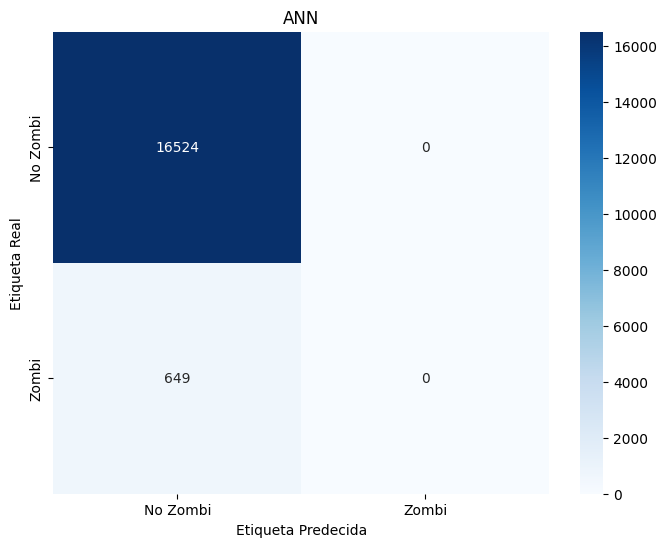

In [ ]:
# Predecir las etiquetas para el conjunto de testeo

y_pred_probs = model_ANN.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(float)


df_metricas.loc["ANN", "Accuracy"] =  accuracy_score(y_test, y_pred)
df_metricas.loc["ANN", "Balanced Accuracy"] = balanced_accuracy(y_test, y_pred.flatten())
df_metricas.loc["ANN", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["ANN", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["ANN", "F1 Score"] = f1_score(y_test,y_pred)
# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('ANN')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

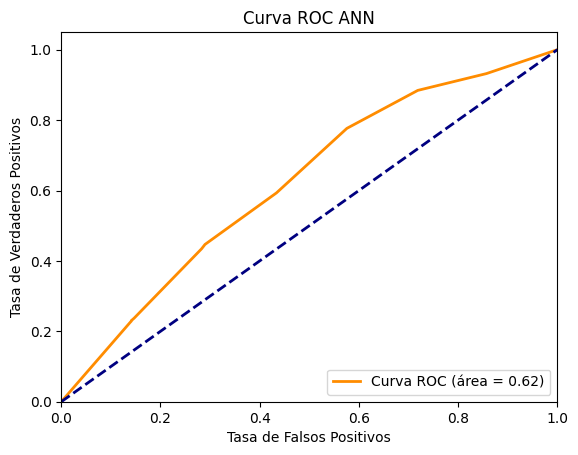

In [ ]:
# Calcular tasas de verdaderos y falsos positivos
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calcular el área bajo la curva ROC
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2  # Grosor de la línea
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC ANN')
plt.legend(loc="lower right")
plt.show()

537/537 [==============================] - 2s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


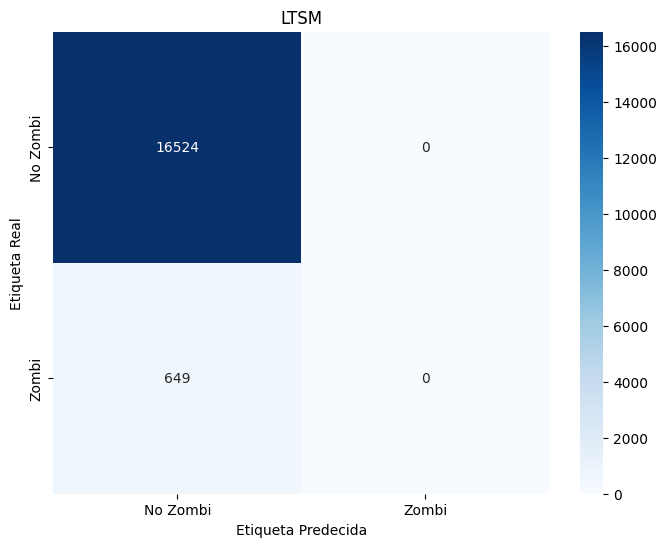

In [ ]:
# Predecir las etiquetas para el conjunto de testeo

y_pred_probs = model_LSTM.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(float)


df_metricas.loc["LTSM", "Accuracy"] =  accuracy_score(y_test, y_pred)
df_metricas.loc["LTSM", "Balanced Accuracy"] = balanced_accuracy(y_test, y_pred.flatten())
df_metricas.loc["LTSM", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["LTSM", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["LTSM", "F1 Score"] = f1_score(y_test,y_pred)
# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('LTSM')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

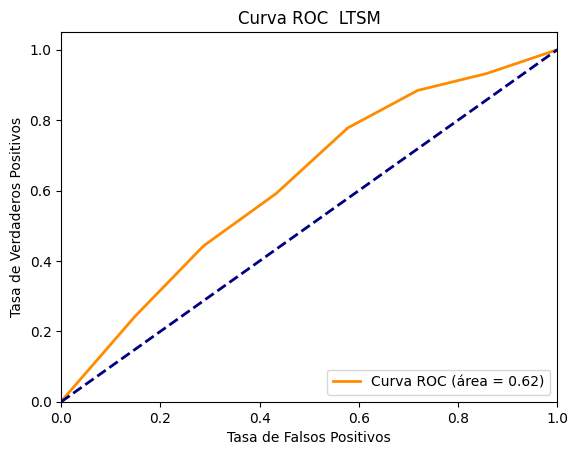

In [ ]:
# Calcular tasas de verdaderos y falsos positivos
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calcular el área bajo la curva ROC
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2  # Grosor de la línea
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC  LTSM')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df_metricas

,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score
ANN,0.962208,0.5,0.0,0.0,0.0
LTSM,0.962208,0.5,0.0,0.0,0.0


In [ ]:
# Calcular relevancia de variables
explainer = shap.Explainer(model_LSTM.predict, X_test)
shap_values = explainer(X_test[:500])

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  10%|█         | 51/500 [00:00<?, ?it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  11%|█         | 53/500 [00:10<00:36, 12.25it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  11%|█         | 55/500 [00:10<01:16,  5.85it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  11%|█         | 56/500 [00:10<01:18,  5.65it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  11%|█▏        | 57/500 [00:11<01:20,  5.50it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  12%|█▏        | 58/500 [00:11<01:20,  5.50it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  12%|█▏        | 59/500 [00:11<01:21,  5.40it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  12%|█▏        | 60/500 [00:11<01:20,  5.45it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  12%|█▏        | 61/500 [00:11<01:23,  5.29it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  12%|█▏        | 62/500 [00:12<01:26,  5.09it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  13%|█▎        | 63/500 [00:12<01:24,  5.17it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  13%|█▎        | 64/500 [00:12<01:26,  5.07it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  13%|█▎        | 65/500 [00:12<01:18,  5.56it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  13%|█▎        | 66/500 [00:12<01:15,  5.77it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  13%|█▎        | 67/500 [00:12<01:11,  6.09it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  14%|█▎        | 68/500 [00:13<01:12,  5.97it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  14%|█▍        | 69/500 [00:13<01:08,  6.29it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  14%|█▍        | 70/500 [00:13<01:06,  6.51it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  14%|█▍        | 71/500 [00:13<01:12,  5.93it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  14%|█▍        | 72/500 [00:13<01:12,  5.90it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  15%|█▍        | 73/500 [00:13<01:07,  6.33it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  15%|█▍        | 74/500 [00:14<01:10,  6.07it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  15%|█▌        | 75/500 [00:14<01:07,  6.32it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  15%|█▌        | 76/500 [00:14<01:02,  6.74it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  15%|█▌        | 77/500 [00:14<01:01,  6.85it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  16%|█▌        | 78/500 [00:14<01:09,  6.04it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  16%|█▌        | 79/500 [00:14<01:12,  5.78it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  16%|█▌        | 80/500 [00:15<01:16,  5.48it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  16%|█▌        | 81/500 [00:15<01:16,  5.44it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  16%|█▋        | 82/500 [00:15<01:14,  5.62it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  17%|█▋        | 83/500 [00:15<01:17,  5.38it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  17%|█▋        | 84/500 [00:15<01:18,  5.33it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  17%|█▋        | 85/500 [00:16<01:21,  5.12it/s]

9/9 [==============================] - 0s 6ms/step


ExactExplainer explainer:  17%|█▋        | 86/500 [00:16<01:18,  5.26it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  17%|█▋        | 87/500 [00:16<01:16,  5.41it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  18%|█▊        | 88/500 [00:16<01:14,  5.55it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  18%|█▊        | 89/500 [00:16<01:16,  5.36it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  18%|█▊        | 90/500 [00:17<01:17,  5.30it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  18%|█▊        | 91/500 [00:17<01:15,  5.43it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  18%|█▊        | 92/500 [00:17<01:15,  5.40it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  19%|█▊        | 93/500 [00:17<01:12,  5.64it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  19%|█▉        | 94/500 [00:17<01:09,  5.82it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  19%|█▉        | 95/500 [00:17<01:07,  5.96it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  19%|█▉        | 96/500 [00:18<01:08,  5.91it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  19%|█▉        | 97/500 [00:18<01:09,  5.82it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  20%|█▉        | 98/500 [00:18<01:05,  6.10it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  20%|█▉        | 99/500 [00:18<01:08,  5.89it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  20%|██        | 100/500 [00:18<01:06,  6.02it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  20%|██        | 101/500 [00:18<01:06,  6.03it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  20%|██        | 102/500 [00:19<01:07,  5.93it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  21%|██        | 103/500 [00:19<01:09,  5.68it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  21%|██        | 104/500 [00:19<01:06,  5.92it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  21%|██        | 105/500 [00:19<01:10,  5.60it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  21%|██        | 106/500 [00:19<01:07,  5.87it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  21%|██▏       | 107/500 [00:19<01:06,  5.93it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  22%|██▏       | 108/500 [00:20<01:06,  5.93it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  22%|██▏       | 109/500 [00:20<01:02,  6.26it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  22%|██▏       | 110/500 [00:20<01:02,  6.21it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  22%|██▏       | 111/500 [00:20<01:05,  5.96it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  22%|██▏       | 112/500 [00:20<01:02,  6.25it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  23%|██▎       | 113/500 [00:20<00:59,  6.49it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  23%|██▎       | 114/500 [00:21<01:01,  6.30it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  23%|██▎       | 115/500 [00:21<01:03,  6.11it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  23%|██▎       | 116/500 [00:21<01:01,  6.22it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  23%|██▎       | 117/500 [00:21<01:06,  5.78it/s]

9/9 [==============================] - 0s 6ms/step


ExactExplainer explainer:  24%|██▎       | 118/500 [00:21<01:12,  5.27it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  24%|██▍       | 119/500 [00:21<01:15,  5.07it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  24%|██▍       | 120/500 [00:22<01:10,  5.39it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  24%|██▍       | 121/500 [00:22<01:07,  5.61it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  24%|██▍       | 122/500 [00:22<01:04,  5.88it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  25%|██▍       | 123/500 [00:22<01:01,  6.15it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  25%|██▍       | 124/500 [00:22<01:00,  6.21it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  25%|██▌       | 125/500 [00:22<01:03,  5.91it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  25%|██▌       | 126/500 [00:23<01:02,  5.97it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  25%|██▌       | 127/500 [00:23<00:59,  6.25it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  26%|██▌       | 128/500 [00:23<01:00,  6.20it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  26%|██▌       | 129/500 [00:23<00:59,  6.23it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  26%|██▌       | 130/500 [00:23<00:59,  6.18it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  26%|██▌       | 131/500 [00:23<00:56,  6.51it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  26%|██▋       | 132/500 [00:24<00:57,  6.35it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  27%|██▋       | 133/500 [00:24<00:55,  6.67it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  27%|██▋       | 134/500 [00:24<00:53,  6.87it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  27%|██▋       | 135/500 [00:24<00:59,  6.16it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  27%|██▋       | 136/500 [00:24<00:58,  6.26it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  27%|██▋       | 137/500 [00:24<00:57,  6.31it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  28%|██▊       | 138/500 [00:24<00:59,  6.04it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  28%|██▊       | 139/500 [00:25<01:00,  5.96it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  28%|██▊       | 140/500 [00:25<01:00,  5.97it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  28%|██▊       | 141/500 [00:25<01:01,  5.81it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  28%|██▊       | 142/500 [00:25<00:59,  6.06it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  29%|██▊       | 143/500 [00:25<00:59,  6.01it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  29%|██▉       | 144/500 [00:26<01:01,  5.82it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  29%|██▉       | 145/500 [00:26<00:58,  6.04it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  29%|██▉       | 146/500 [00:26<00:57,  6.15it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  29%|██▉       | 147/500 [00:26<00:59,  5.92it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  30%|██▉       | 148/500 [00:26<00:57,  6.17it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  30%|██▉       | 149/500 [00:26<00:55,  6.37it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  30%|███       | 150/500 [00:27<00:59,  5.86it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  30%|███       | 151/500 [00:27<01:01,  5.71it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  30%|███       | 152/500 [00:27<00:56,  6.15it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  31%|███       | 153/500 [00:27<00:53,  6.51it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  31%|███       | 154/500 [00:27<00:56,  6.17it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  31%|███       | 155/500 [00:27<00:55,  6.19it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  31%|███       | 156/500 [00:27<00:56,  6.05it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  31%|███▏      | 157/500 [00:28<00:55,  6.24it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  32%|███▏      | 158/500 [00:28<00:53,  6.41it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  32%|███▏      | 159/500 [00:28<00:52,  6.53it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  32%|███▏      | 160/500 [00:28<00:53,  6.38it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  32%|███▏      | 161/500 [00:28<00:51,  6.60it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  32%|███▏      | 162/500 [00:28<00:49,  6.84it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  33%|███▎      | 163/500 [00:29<00:51,  6.50it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  33%|███▎      | 164/500 [00:29<00:54,  6.20it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  33%|███▎      | 165/500 [00:29<00:54,  6.15it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  33%|███▎      | 166/500 [00:29<00:51,  6.47it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  33%|███▎      | 167/500 [00:29<00:48,  6.80it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  34%|███▎      | 168/500 [00:29<00:48,  6.89it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  34%|███▍      | 169/500 [00:29<00:47,  6.92it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  34%|███▍      | 170/500 [00:30<00:48,  6.80it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  34%|███▍      | 171/500 [00:30<00:53,  6.21it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  34%|███▍      | 172/500 [00:30<00:50,  6.49it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  35%|███▍      | 173/500 [00:30<00:48,  6.75it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  35%|███▍      | 174/500 [00:30<00:49,  6.58it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  35%|███▌      | 175/500 [00:30<00:48,  6.74it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  35%|███▌      | 176/500 [00:30<00:46,  6.96it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  35%|███▌      | 177/500 [00:31<00:46,  6.99it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  36%|███▌      | 178/500 [00:31<00:47,  6.77it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  36%|███▌      | 179/500 [00:31<00:51,  6.26it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  36%|███▌      | 180/500 [00:31<00:53,  6.03it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  36%|███▌      | 181/500 [00:31<00:56,  5.63it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  36%|███▋      | 182/500 [00:32<00:56,  5.64it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  37%|███▋      | 183/500 [00:32<00:58,  5.46it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  37%|███▋      | 184/500 [00:32<00:57,  5.49it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  37%|███▋      | 185/500 [00:32<00:56,  5.53it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  37%|███▋      | 186/500 [00:32<00:56,  5.54it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  37%|███▋      | 187/500 [00:32<00:57,  5.40it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  38%|███▊      | 188/500 [00:33<00:58,  5.29it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  38%|███▊      | 189/500 [00:33<01:00,  5.11it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  38%|███▊      | 190/500 [00:33<00:56,  5.48it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  38%|███▊      | 191/500 [00:33<00:59,  5.22it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  38%|███▊      | 192/500 [00:33<00:58,  5.28it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  39%|███▊      | 193/500 [00:34<00:53,  5.73it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  39%|███▉      | 194/500 [00:34<00:50,  6.00it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  39%|███▉      | 195/500 [00:34<00:49,  6.14it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  39%|███▉      | 196/500 [00:34<00:47,  6.38it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  39%|███▉      | 197/500 [00:34<00:50,  6.05it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  40%|███▉      | 198/500 [00:34<00:52,  5.74it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  40%|███▉      | 199/500 [00:35<00:51,  5.88it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  40%|████      | 200/500 [00:35<00:51,  5.78it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  40%|████      | 201/500 [00:35<00:50,  5.92it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  40%|████      | 202/500 [00:35<00:49,  6.05it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  41%|████      | 203/500 [00:35<00:48,  6.18it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  41%|████      | 204/500 [00:35<00:49,  5.96it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  41%|████      | 205/500 [00:36<00:48,  6.09it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  41%|████      | 206/500 [00:36<00:51,  5.69it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  41%|████▏     | 207/500 [00:36<00:48,  6.01it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  42%|████▏     | 208/500 [00:36<00:47,  6.08it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  42%|████▏     | 209/500 [00:36<00:46,  6.28it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  42%|████▏     | 210/500 [00:36<00:49,  5.85it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  42%|████▏     | 211/500 [00:37<00:52,  5.50it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  42%|████▏     | 212/500 [00:37<00:48,  5.89it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  43%|████▎     | 213/500 [00:37<00:48,  5.93it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  43%|████▎     | 214/500 [00:37<00:45,  6.28it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  43%|████▎     | 215/500 [00:37<00:44,  6.42it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  43%|████▎     | 216/500 [00:37<00:45,  6.20it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  43%|████▎     | 217/500 [00:37<00:44,  6.30it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  44%|████▎     | 218/500 [00:38<00:44,  6.35it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  44%|████▍     | 219/500 [00:38<00:43,  6.50it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  44%|████▍     | 220/500 [00:38<00:44,  6.26it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  44%|████▍     | 221/500 [00:38<00:43,  6.39it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  44%|████▍     | 222/500 [00:38<00:42,  6.54it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  45%|████▍     | 223/500 [00:38<00:43,  6.42it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  45%|████▍     | 224/500 [00:39<00:46,  5.97it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  45%|████▌     | 225/500 [00:39<00:48,  5.65it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  45%|████▌     | 226/500 [00:39<00:46,  5.84it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  45%|████▌     | 227/500 [00:39<00:44,  6.18it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  46%|████▌     | 228/500 [00:39<00:46,  5.82it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  46%|████▌     | 229/500 [00:39<00:43,  6.20it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  46%|████▌     | 230/500 [00:40<00:43,  6.23it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  46%|████▌     | 231/500 [00:40<00:44,  6.02it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  46%|████▋     | 232/500 [00:40<00:46,  5.81it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  47%|████▋     | 233/500 [00:40<00:48,  5.53it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  47%|████▋     | 234/500 [00:40<00:44,  5.92it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  47%|████▋     | 235/500 [00:40<00:44,  6.00it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  47%|████▋     | 236/500 [00:41<00:42,  6.18it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  47%|████▋     | 237/500 [00:41<00:43,  5.99it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  48%|████▊     | 238/500 [00:41<00:44,  5.86it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  48%|████▊     | 239/500 [00:41<00:46,  5.57it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  48%|████▊     | 240/500 [00:41<00:44,  5.80it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  48%|████▊     | 241/500 [00:41<00:42,  6.03it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  48%|████▊     | 242/500 [00:42<00:42,  6.11it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  49%|████▊     | 243/500 [00:42<00:42,  6.02it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  49%|████▉     | 244/500 [00:42<00:40,  6.29it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  49%|████▉     | 245/500 [00:42<00:42,  5.98it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  49%|████▉     | 246/500 [00:42<00:40,  6.22it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  49%|████▉     | 247/500 [00:42<00:42,  5.89it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  50%|████▉     | 248/500 [00:43<00:43,  5.85it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  50%|████▉     | 249/500 [00:43<00:43,  5.75it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  50%|█████     | 250/500 [00:43<00:41,  5.98it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  50%|█████     | 251/500 [00:43<00:42,  5.91it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  50%|█████     | 252/500 [00:43<00:41,  5.94it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  51%|█████     | 253/500 [00:43<00:39,  6.27it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  51%|█████     | 254/500 [00:44<00:42,  5.77it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  51%|█████     | 255/500 [00:44<00:44,  5.47it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  51%|█████     | 256/500 [00:44<00:41,  5.82it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  51%|█████▏    | 257/500 [00:44<00:42,  5.77it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  52%|█████▏    | 258/500 [00:44<00:42,  5.70it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  52%|█████▏    | 259/500 [00:45<00:41,  5.87it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  52%|█████▏    | 260/500 [00:45<00:41,  5.74it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  52%|█████▏    | 261/500 [00:45<00:41,  5.74it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  52%|█████▏    | 262/500 [00:45<00:43,  5.49it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  53%|█████▎    | 263/500 [00:45<00:41,  5.75it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  53%|█████▎    | 264/500 [00:45<00:39,  6.05it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  53%|█████▎    | 265/500 [00:46<00:37,  6.20it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  53%|█████▎    | 266/500 [00:46<00:41,  5.69it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  53%|█████▎    | 267/500 [00:46<00:42,  5.49it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  54%|█████▎    | 268/500 [00:46<00:41,  5.63it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  54%|█████▍    | 269/500 [00:46<00:39,  5.80it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  54%|█████▍    | 270/500 [00:47<00:43,  5.28it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  54%|█████▍    | 271/500 [00:47<00:47,  4.85it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  54%|█████▍    | 272/500 [00:47<00:47,  4.84it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  55%|█████▍    | 273/500 [00:47<00:44,  5.13it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  55%|█████▍    | 274/500 [00:47<00:41,  5.41it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  55%|█████▌    | 275/500 [00:47<00:41,  5.45it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  55%|█████▌    | 276/500 [00:48<00:39,  5.72it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  55%|█████▌    | 277/500 [00:48<00:39,  5.64it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  56%|█████▌    | 278/500 [00:48<00:39,  5.58it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  56%|█████▌    | 279/500 [00:48<00:38,  5.74it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  56%|█████▌    | 280/500 [00:48<00:40,  5.44it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  56%|█████▌    | 281/500 [00:49<00:40,  5.36it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  56%|█████▋    | 282/500 [00:49<00:40,  5.40it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  57%|█████▋    | 283/500 [00:49<00:40,  5.34it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  57%|█████▋    | 284/500 [00:49<00:39,  5.49it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  57%|█████▋    | 285/500 [00:49<00:38,  5.54it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  57%|█████▋    | 286/500 [00:49<00:36,  5.84it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  57%|█████▋    | 287/500 [00:50<00:35,  5.97it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  58%|█████▊    | 288/500 [00:50<00:37,  5.65it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  58%|█████▊    | 289/500 [00:50<00:38,  5.53it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  58%|█████▊    | 290/500 [00:50<00:38,  5.44it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  58%|█████▊    | 291/500 [00:50<00:36,  5.70it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  58%|█████▊    | 292/500 [00:51<00:36,  5.75it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  59%|█████▊    | 293/500 [00:51<00:37,  5.47it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  59%|█████▉    | 294/500 [00:51<00:36,  5.64it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  59%|█████▉    | 295/500 [00:51<00:38,  5.27it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  59%|█████▉    | 296/500 [00:51<00:38,  5.31it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  59%|█████▉    | 297/500 [00:51<00:37,  5.46it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  60%|█████▉    | 298/500 [00:52<00:35,  5.76it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  60%|█████▉    | 299/500 [00:52<00:33,  6.00it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  60%|██████    | 300/500 [00:52<00:32,  6.21it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  60%|██████    | 301/500 [00:52<00:32,  6.12it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  60%|██████    | 302/500 [00:52<00:31,  6.32it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  61%|██████    | 303/500 [00:52<00:31,  6.26it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  61%|██████    | 304/500 [00:53<00:33,  5.86it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  61%|██████    | 305/500 [00:53<00:35,  5.54it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  61%|██████    | 306/500 [00:53<00:34,  5.65it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  61%|██████▏   | 307/500 [00:53<00:36,  5.29it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  62%|██████▏   | 308/500 [00:53<00:33,  5.67it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  62%|██████▏   | 309/500 [00:54<00:35,  5.39it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  62%|██████▏   | 310/500 [00:54<00:35,  5.35it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  62%|██████▏   | 311/500 [00:54<00:33,  5.63it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  62%|██████▏   | 312/500 [00:54<00:33,  5.60it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  63%|██████▎   | 313/500 [00:54<00:33,  5.57it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  63%|██████▎   | 314/500 [00:54<00:34,  5.43it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  63%|██████▎   | 315/500 [00:55<00:32,  5.72it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  63%|██████▎   | 316/500 [00:55<00:33,  5.47it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  63%|██████▎   | 317/500 [00:55<00:31,  5.86it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  64%|██████▎   | 318/500 [00:55<00:29,  6.14it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  64%|██████▍   | 319/500 [00:55<00:30,  5.96it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  64%|██████▍   | 320/500 [00:55<00:30,  5.90it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  64%|██████▍   | 321/500 [00:56<00:28,  6.18it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  64%|██████▍   | 322/500 [00:56<00:29,  5.99it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  65%|██████▍   | 323/500 [00:56<00:28,  6.20it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  65%|██████▍   | 324/500 [00:56<00:28,  6.19it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  65%|██████▌   | 325/500 [00:56<00:29,  5.90it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  65%|██████▌   | 326/500 [00:56<00:28,  6.09it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  65%|██████▌   | 327/500 [00:57<00:27,  6.24it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  66%|██████▌   | 328/500 [00:57<00:28,  5.97it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  66%|██████▌   | 329/500 [00:57<00:29,  5.78it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  66%|██████▌   | 330/500 [00:57<00:29,  5.67it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  66%|██████▌   | 331/500 [00:57<00:28,  5.89it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  66%|██████▋   | 332/500 [00:57<00:28,  5.84it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  67%|██████▋   | 333/500 [00:58<00:29,  5.58it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  67%|██████▋   | 334/500 [00:58<00:28,  5.88it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  67%|██████▋   | 335/500 [00:58<00:26,  6.28it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  67%|██████▋   | 336/500 [00:58<00:26,  6.17it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  67%|██████▋   | 337/500 [00:58<00:27,  5.91it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  68%|██████▊   | 338/500 [00:58<00:28,  5.63it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  68%|██████▊   | 339/500 [00:59<00:26,  6.04it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  68%|██████▊   | 340/500 [00:59<00:25,  6.35it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  68%|██████▊   | 341/500 [00:59<00:25,  6.14it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  68%|██████▊   | 342/500 [00:59<00:25,  6.22it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  69%|██████▊   | 343/500 [00:59<00:24,  6.41it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  69%|██████▉   | 344/500 [00:59<00:26,  5.93it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  69%|██████▉   | 345/500 [01:00<00:25,  5.98it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  69%|██████▉   | 346/500 [01:00<00:27,  5.55it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  69%|██████▉   | 347/500 [01:00<00:27,  5.58it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  70%|██████▉   | 348/500 [01:00<00:26,  5.84it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  70%|██████▉   | 349/500 [01:00<00:24,  6.06it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  70%|███████   | 350/500 [01:00<00:25,  5.86it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  70%|███████   | 351/500 [01:01<00:25,  5.82it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  70%|███████   | 352/500 [01:01<00:26,  5.49it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  71%|███████   | 353/500 [01:01<00:26,  5.64it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  71%|███████   | 354/500 [01:01<00:26,  5.61it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  71%|███████   | 355/500 [01:01<00:26,  5.37it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  71%|███████   | 356/500 [01:02<00:24,  5.78it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  71%|███████▏  | 357/500 [01:02<00:23,  6.19it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  72%|███████▏  | 358/500 [01:02<00:22,  6.29it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  72%|███████▏  | 359/500 [01:02<00:23,  6.05it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  72%|███████▏  | 360/500 [01:02<00:23,  5.85it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  72%|███████▏  | 361/500 [01:02<00:23,  6.04it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  72%|███████▏  | 362/500 [01:02<00:22,  6.14it/s]

9/9 [==============================] - 0s 7ms/step


ExactExplainer explainer:  73%|███████▎  | 363/500 [01:03<00:28,  4.84it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  73%|███████▎  | 364/500 [01:03<00:26,  5.16it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  73%|███████▎  | 365/500 [01:03<00:24,  5.55it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  73%|███████▎  | 366/500 [01:03<00:24,  5.44it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  73%|███████▎  | 367/500 [01:03<00:23,  5.64it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  74%|███████▎  | 368/500 [01:04<00:22,  5.97it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  74%|███████▍  | 369/500 [01:04<00:22,  5.80it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  74%|███████▍  | 370/500 [01:04<00:21,  5.97it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  74%|███████▍  | 371/500 [01:04<00:22,  5.66it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  74%|███████▍  | 372/500 [01:04<00:23,  5.42it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  75%|███████▍  | 373/500 [01:04<00:22,  5.68it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  75%|███████▍  | 374/500 [01:05<00:21,  5.94it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  75%|███████▌  | 375/500 [01:05<00:21,  5.78it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  75%|███████▌  | 376/500 [01:05<00:22,  5.45it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  75%|███████▌  | 377/500 [01:05<00:22,  5.59it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  76%|███████▌  | 378/500 [01:05<00:20,  5.94it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  76%|███████▌  | 379/500 [01:05<00:19,  6.19it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  76%|███████▌  | 380/500 [01:06<00:20,  5.99it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  76%|███████▌  | 381/500 [01:06<00:19,  6.07it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  76%|███████▋  | 382/500 [01:06<00:18,  6.32it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  77%|███████▋  | 383/500 [01:07<00:34,  3.41it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  77%|███████▋  | 384/500 [01:07<00:30,  3.85it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  77%|███████▋  | 385/500 [01:07<00:26,  4.32it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  77%|███████▋  | 386/500 [01:07<00:24,  4.74it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  77%|███████▋  | 387/500 [01:07<00:23,  4.79it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  78%|███████▊  | 388/500 [01:08<00:24,  4.63it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  78%|███████▊  | 389/500 [01:08<00:23,  4.83it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  78%|███████▊  | 390/500 [01:08<00:21,  5.06it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  78%|███████▊  | 391/500 [01:08<00:20,  5.32it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  78%|███████▊  | 392/500 [01:08<00:21,  5.02it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  79%|███████▊  | 393/500 [01:08<00:20,  5.25it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  79%|███████▉  | 394/500 [01:09<00:19,  5.37it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  79%|███████▉  | 395/500 [01:09<00:20,  5.10it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  79%|███████▉  | 396/500 [01:09<00:19,  5.23it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  79%|███████▉  | 397/500 [01:09<00:19,  5.41it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  80%|███████▉  | 398/500 [01:09<00:18,  5.50it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  80%|███████▉  | 399/500 [01:10<00:18,  5.41it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  80%|████████  | 400/500 [01:10<00:18,  5.47it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  80%|████████  | 401/500 [01:10<00:17,  5.56it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  80%|████████  | 402/500 [01:10<00:17,  5.62it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  81%|████████  | 403/500 [01:10<00:17,  5.51it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  81%|████████  | 404/500 [01:10<00:18,  5.19it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  81%|████████  | 405/500 [01:11<00:18,  5.18it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  81%|████████  | 406/500 [01:11<00:18,  5.14it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  81%|████████▏ | 407/500 [01:11<00:17,  5.37it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  82%|████████▏ | 408/500 [01:11<00:17,  5.24it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  82%|████████▏ | 409/500 [01:11<00:17,  5.10it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  82%|████████▏ | 410/500 [01:12<00:17,  5.03it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  82%|████████▏ | 411/500 [01:12<00:17,  5.10it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  82%|████████▏ | 412/500 [01:12<00:17,  5.04it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  83%|████████▎ | 413/500 [01:12<00:16,  5.30it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  83%|████████▎ | 414/500 [01:12<00:17,  4.96it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  83%|████████▎ | 415/500 [01:13<00:16,  5.10it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  83%|████████▎ | 416/500 [01:13<00:17,  4.93it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  83%|████████▎ | 417/500 [01:13<00:16,  5.14it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  84%|████████▎ | 418/500 [01:13<00:16,  4.90it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  84%|████████▍ | 419/500 [01:13<00:15,  5.16it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  84%|████████▍ | 420/500 [01:14<00:15,  5.27it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  84%|████████▍ | 421/500 [01:14<00:15,  5.14it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  84%|████████▍ | 422/500 [01:14<00:14,  5.26it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  85%|████████▍ | 423/500 [01:14<00:16,  4.76it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  85%|████████▍ | 424/500 [01:14<00:15,  5.06it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  85%|████████▌ | 425/500 [01:15<00:15,  4.91it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  85%|████████▌ | 426/500 [01:15<00:14,  5.13it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  85%|████████▌ | 427/500 [01:15<00:13,  5.30it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  86%|████████▌ | 428/500 [01:15<00:14,  5.02it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  86%|████████▌ | 429/500 [01:15<00:13,  5.35it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  86%|████████▌ | 430/500 [01:16<00:12,  5.51it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  86%|████████▌ | 431/500 [01:16<00:12,  5.48it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  86%|████████▋ | 432/500 [01:16<00:12,  5.62it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  87%|████████▋ | 433/500 [01:16<00:12,  5.56it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  87%|████████▋ | 434/500 [01:16<00:12,  5.45it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  87%|████████▋ | 435/500 [01:16<00:12,  5.23it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  87%|████████▋ | 436/500 [01:17<00:12,  5.24it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  87%|████████▋ | 437/500 [01:17<00:12,  5.10it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  88%|████████▊ | 438/500 [01:17<00:12,  5.03it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  88%|████████▊ | 439/500 [01:17<00:11,  5.32it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  88%|████████▊ | 440/500 [01:17<00:11,  5.43it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  88%|████████▊ | 441/500 [01:18<00:11,  5.36it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  88%|████████▊ | 442/500 [01:18<00:10,  5.36it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  89%|████████▊ | 443/500 [01:18<00:10,  5.28it/s]

9/9 [==============================] - 0s 8ms/step


ExactExplainer explainer:  89%|████████▉ | 444/500 [01:18<00:12,  4.58it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  89%|████████▉ | 445/500 [01:18<00:11,  4.66it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  89%|████████▉ | 446/500 [01:19<00:11,  4.75it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  89%|████████▉ | 447/500 [01:19<00:10,  5.13it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  90%|████████▉ | 448/500 [01:19<00:09,  5.27it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  90%|████████▉ | 449/500 [01:19<00:09,  5.20it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  90%|█████████ | 450/500 [01:19<00:09,  5.17it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  90%|█████████ | 451/500 [01:20<00:09,  5.42it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  90%|█████████ | 452/500 [01:20<00:08,  5.45it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  91%|█████████ | 453/500 [01:20<00:08,  5.26it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  91%|█████████ | 454/500 [01:20<00:08,  5.22it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  91%|█████████ | 455/500 [01:20<00:08,  5.30it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  91%|█████████ | 456/500 [01:21<00:08,  5.50it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  91%|█████████▏| 457/500 [01:21<00:07,  5.61it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  92%|█████████▏| 458/500 [01:21<00:07,  5.74it/s]

9/9 [==============================] - 0s 6ms/step


ExactExplainer explainer:  92%|█████████▏| 459/500 [01:21<00:07,  5.66it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  92%|█████████▏| 460/500 [01:21<00:07,  5.55it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  92%|█████████▏| 461/500 [01:21<00:06,  5.68it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  92%|█████████▏| 462/500 [01:22<00:07,  5.36it/s]

9/9 [==============================] - 0s 6ms/step


ExactExplainer explainer:  93%|█████████▎| 463/500 [01:22<00:07,  4.87it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  93%|█████████▎| 464/500 [01:22<00:07,  4.79it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  93%|█████████▎| 465/500 [01:22<00:07,  4.48it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  93%|█████████▎| 466/500 [01:22<00:07,  4.75it/s]

9/9 [==============================] - 0s 6ms/step


ExactExplainer explainer:  93%|█████████▎| 467/500 [01:23<00:06,  4.79it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  94%|█████████▎| 468/500 [01:23<00:06,  4.75it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  94%|█████████▍| 469/500 [01:23<00:06,  4.95it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  94%|█████████▍| 470/500 [01:23<00:06,  4.88it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  94%|█████████▍| 471/500 [01:23<00:05,  5.07it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  94%|█████████▍| 472/500 [01:24<00:05,  4.79it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  95%|█████████▍| 473/500 [01:24<00:05,  4.71it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  95%|█████████▍| 474/500 [01:24<00:05,  4.89it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  95%|█████████▌| 475/500 [01:24<00:05,  4.93it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  95%|█████████▌| 476/500 [01:25<00:04,  5.05it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  95%|█████████▌| 477/500 [01:25<00:04,  5.01it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  96%|█████████▌| 478/500 [01:25<00:04,  5.40it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  96%|█████████▌| 479/500 [01:25<00:03,  5.52it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  96%|█████████▌| 480/500 [01:25<00:03,  5.48it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  96%|█████████▌| 481/500 [01:25<00:03,  5.23it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  96%|█████████▋| 482/500 [01:26<00:03,  5.38it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  97%|█████████▋| 483/500 [01:26<00:03,  5.21it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  97%|█████████▋| 484/500 [01:26<00:03,  5.06it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  97%|█████████▋| 485/500 [01:26<00:03,  4.95it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  97%|█████████▋| 486/500 [01:26<00:02,  5.11it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer:  97%|█████████▋| 487/500 [01:27<00:02,  5.08it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  98%|█████████▊| 488/500 [01:27<00:02,  4.96it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  98%|█████████▊| 489/500 [01:27<00:02,  5.07it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  98%|█████████▊| 490/500 [01:27<00:01,  5.35it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  98%|█████████▊| 491/500 [01:27<00:01,  5.54it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  98%|█████████▊| 492/500 [01:28<00:01,  5.53it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  99%|█████████▊| 493/500 [01:28<00:01,  5.86it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer:  99%|█████████▉| 494/500 [01:28<00:01,  5.92it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  99%|█████████▉| 495/500 [01:28<00:00,  6.25it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  99%|█████████▉| 496/500 [01:28<00:00,  6.16it/s]

9/9 [==============================] - 0s 3ms/step


ExactExplainer explainer:  99%|█████████▉| 497/500 [01:28<00:00,  6.06it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer: 100%|█████████▉| 498/500 [01:29<00:00,  5.49it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer: 100%|█████████▉| 499/500 [01:29<00:00,  5.66it/s]

9/9 [==============================] - 0s 5ms/step


ExactExplainer explainer: 100%|██████████| 500/500 [01:29<00:00,  5.80it/s]

9/9 [==============================] - 0s 4ms/step


ExactExplainer explainer: 501it [01:29,  5.02it/s]


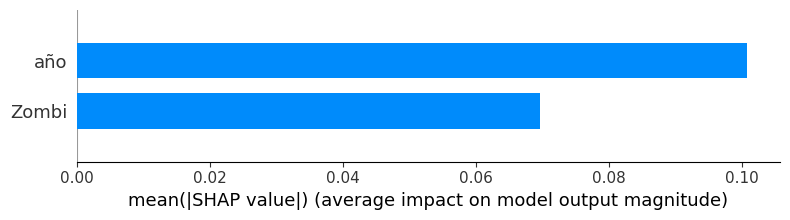

In [ ]:

# Crear un gráfico de barras
shap.summary_plot(shap_values, title="Relevancia de variables", plot_type='bar', feature_names=feature_columns)
